AUTHORS: SEDA AYKUTLU -  JUAN MORALES CONDE    

In [1]:
# -----------------------------------------------------------
# LIBRARIES
# -----------------------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data2 = pd.read_csv('electrical_grid_stability.csv')

In [3]:
seed=1
data = data2.sample(frac=0.20,random_state=seed)
del(data2)

In [4]:
data.shape[0]

2000

## Phase 1 — Data Exploration


In [5]:
data.head(1)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
9953,6.877876,4.11382,9.356768,8.299753,4.056779,-1.89747,-1.590581,-0.568728,0.276567,0.845536,0.11244,0.822562,0.041969,unstable


Transform the target type  string to number:
- Unstable = 1
- Estable = 0

In [6]:
data['stabf'] = LabelEncoder().fit_transform(data['stabf'])

In [7]:
data.head(1)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
9953,6.877876,4.11382,9.356768,8.299753,4.056779,-1.89747,-1.590581,-0.568728,0.276567,0.845536,0.11244,0.822562,0.041969,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 9953 to 2745
Data columns (total 14 columns):
tau1     2000 non-null float64
tau2     2000 non-null float64
tau3     2000 non-null float64
tau4     2000 non-null float64
p1       2000 non-null float64
p2       2000 non-null float64
p3       2000 non-null float64
p4       2000 non-null float64
g1       2000 non-null float64
g2       2000 non-null float64
g3       2000 non-null float64
g4       2000 non-null float64
stab     2000 non-null float64
stabf    2000 non-null int64
dtypes: float64(13), int64(1)
memory usage: 234.4 KB


In [9]:
X = data.drop(["stabf"],axis=1)
y = data["stabf"]

1    1288
0     712
Name: stabf, dtype: int64


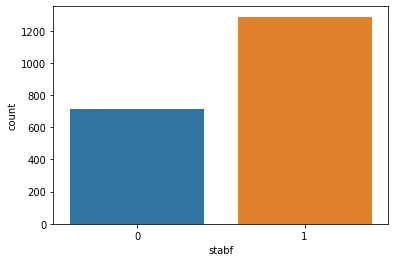

In [10]:
#Number of samples per category

print(data['stabf'].value_counts())
sns.countplot(data['stabf'],label="Count")

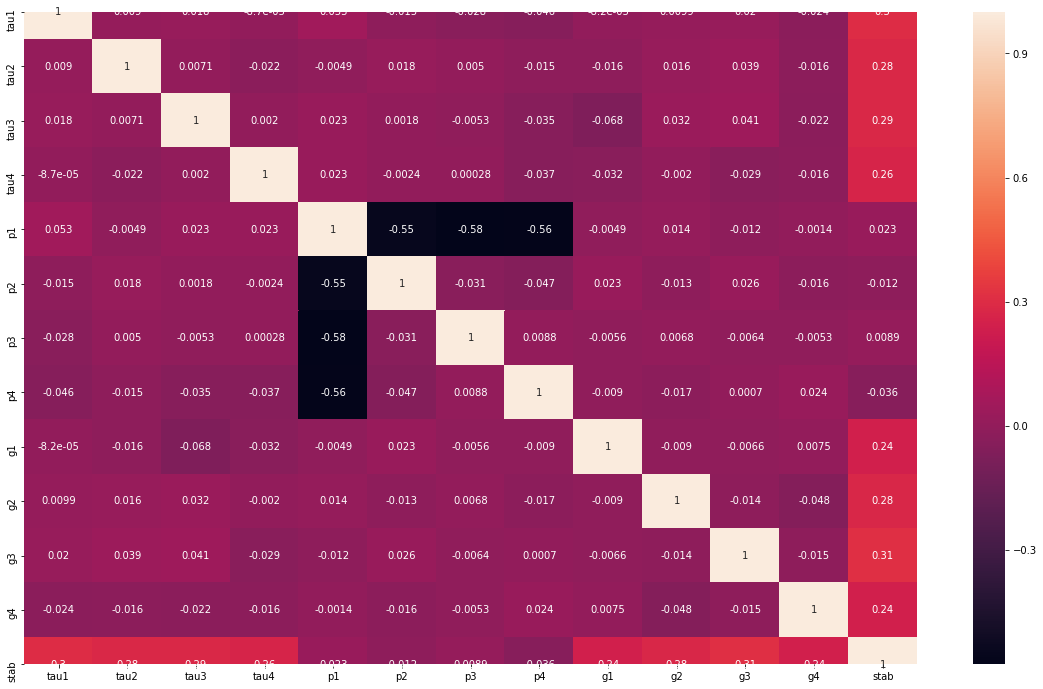

In [11]:
plt.figure(figsize=(20,12))
sns.heatmap(X.corr(),annot=True)

We have obtained the heatmap of correlation among the variables. The color palette in the side represents the amount of correlation among the variables. The lighter shade represents high correlation.We can see that p1 feature is very less correlated to p2,p3 and p4. 

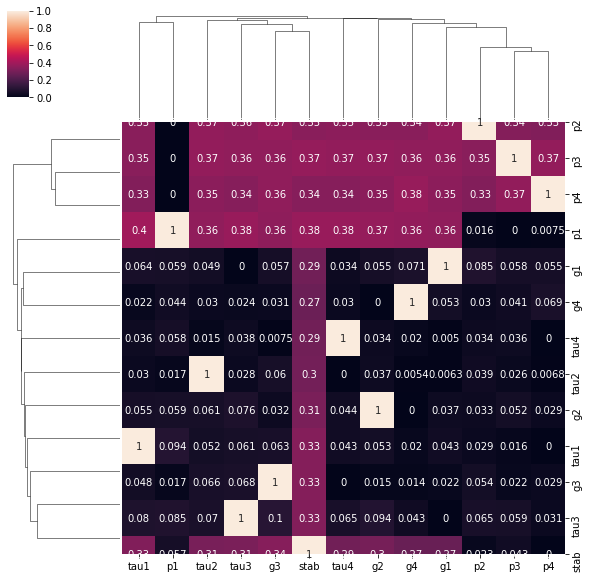

In [12]:
sns.clustermap(X.corr(),standard_scale=0,annot=True)

In [13]:
high_correlation = data.corr().abs()
high_correlation_unstack = high_correlation.unstack()
high_correlation_sort = high_correlation_unstack.sort_values(ascending=False)
 
print(high_correlation_sort[14:25])

stab   stabf    0.823651
stabf  stab     0.823651
p1     p3       0.576035
p3     p1       0.576035
p4     p1       0.564162
p1     p4       0.564162
p2     p1       0.551243
p1     p2       0.551243
g3     stab     0.314272
stab   g3       0.314272
tau1   stab     0.301774
dtype: float64


Here is a list of feature couples sorting by their correlation and its cluster map. In both figure, we can see that stab p1 p2 p3 p4 are highly correlated to each other.

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y,test_size=0.20)

In [15]:
X_train.shape

(1600, 13)

In [16]:
X_test.shape

(400, 13)

## Phase 2 — Feature Scaling and Application of PCA


In [17]:
#NORMALIZING DATA
miStdScaler = StandardScaler()
X_train = miStdScaler.fit_transform(X_train)
X_test = miStdScaler.fit_transform(X_test)

In [18]:
variance = []
for i in range(2,14):
    miPCA = PCA(n_components=i)
    miPCA.fit(X_train)
    variance.append(sum(miPCA.explained_variance_ratio_))

In [19]:
variance

[0.2897074819962009,
 0.37504237511395855,
 0.45839352590517324,
 0.5395665147765141,
 0.617865789456048,
 0.6934329380458994,
 0.7677603274164077,
 0.8415627218179732,
 0.9151531406375617,
 0.9846984035719604,
 0.9999999999999998,
 0.9999999999999998]

Text(0, 0.5, 'Variance ratio')

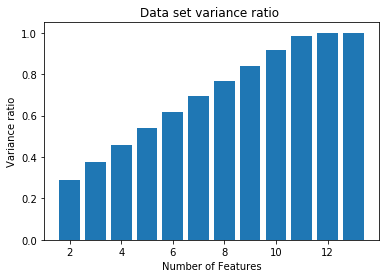

In [20]:
from matplotlib import pyplot as plt

plt.bar(range(2,14),variance)
plt.title('Data set variance ratio ')
plt.xlabel('Number of Features')
plt.ylabel('Variance ratio')

Here is a variance ratio in terms of features. We have 13 features in our dataset and considering the above graph, ideal pca would be decrease it to 9 feature. Because after 9th feature, variation rate keeps steady and there will be no big accuracy change while modelling the dataset. However, for now we decreased it to 2 feature in order to prevent memory and time issues and to be able to plot contour in the following lines.

In [21]:
miPCA = PCA(n_components=2)
miPCA.fit(X_train)
X_train_pca = miPCA.transform(X_train)
X_test_pca = miPCA.transform(X_test)

## Phase 3 — Model Selection with Cross Validation


Classification Models

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


def models(X_train,Y_train,X_test,Y_test):
    result_dic={}
  #Using KNeighborsClassifier
    dic2={}
    miknn = KNeighborsClassifier()   
    migrid = {"n_neighbors" : [1,3,5,7,9],"weights":["distance","uniform"],"metric":["minkowski","manhattan"],
          "p":[1,2,3]}
    migscv = GridSearchCV(estimator=miknn,param_grid=migrid,scoring="accuracy",cv=5,verbose=0,n_jobs=5)
    migscv.fit(X_train, Y_train)
    
    miknnopt = migscv.best_estimator_

    y_pred_knn = miknnopt.predict(X_test)
    t_pred_knn = miknnopt.predict(X_train)
    
    dic2= dict(zip(['Test Acc','Train Acc','CV Acc'],[100*accuracy_score(Y_test,y_pred_knn), 100*accuracy_score(Y_train,t_pred_knn),100*migscv.best_score_]))
    result_dic['KNN']=dic2
    
  #Using SVC linear
    dic2={}
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    lin_gscv = GridSearchCV(svc_lin, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy")
    lin_gscv.fit(X_train, Y_train)
    
    best_lin = lin_gscv.best_estimator_
    
    y_pred_svc1 = best_lin.predict(X_test)
    t_pred_svc1 = best_lin.predict(X_train)
    
    dic2= dict(zip(['Test Acc','Train Acc','CV Acc'],[100*accuracy_score(Y_test,y_pred_svc1), 100*accuracy_score(Y_train,t_pred_svc1),100*lin_gscv.best_score_]))
    result_dic['SVC Linear']=dic2
    
  #Using SVC rbf
    dic2={}
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    rbf_gscv = GridSearchCV(svc_rbf, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy")
    rbf_gscv.fit(X_train, Y_train)
                  
    best_rbf = rbf_gscv.best_estimator_                  
    
    y_pred_svc2 = best_rbf.predict(X_test)
    t_pred_svc2 = best_rbf.predict(X_train)
    
    dic2= dict(zip(['Test Acc','Train Acc','CV Acc'],[100*accuracy_score(Y_test,y_pred_svc2), 100*accuracy_score(Y_train,t_pred_svc2),100*rbf_gscv.best_score_]))
    result_dic['SVC Gaussian']=dic2
    
  #Using Naive Bayes 
    dic2={}
    gauss = GaussianNB()
    gauss.fit(X_train, Y_train)
    
    y_pred_naive = gauss.predict(X_test)
    t_pred_naive = gauss.predict(X_train)
    
    dic2= dict(zip(['Test Acc','Train Acc','CV Acc'],[100*accuracy_score(Y_test,y_pred_naive), 100*accuracy_score(Y_train,t_pred_naive),'---']))
    result_dic['GNB']=dic2
    
  #Using DecisionTreeClassifier 
    dic2={}
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 15,2)}
    dtree_model=DecisionTreeClassifier()
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy")
    dtree_gscv.fit(X_train, Y_train)
    
    best_tree = dtree_gscv.best_estimator_
    
    y_pred_tree = best_tree.predict(X_test)
    t_pred_tree = best_tree.predict(X_train)
    
    dic2= dict(zip(['Test Acc','Train Acc','CV Acc'],[100*accuracy_score(Y_test,y_pred_tree), 100*accuracy_score(Y_train,t_pred_tree),100*dtree_gscv.best_score_]))
    result_dic['DT']=dic2
  #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    dic2={}
    param_grid = {"n_estimators" : [100, 300, 500, 800],"max_depth" : np.arange(1,20,2)} 

    forest = RandomForestClassifier()
    forest_gscv= GridSearchCV(forest, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy")
    forest_gscv.fit(X_train, Y_train)

    best_forest = forest_gscv.best_estimator_
    
    y_pred_forest = best_forest.predict(X_test)
    t_pred_forest = best_forest.predict(X_train)  
    
    dic2= dict(zip(['Test Acc','Train Acc','CV Acc'],[100*accuracy_score(Y_test,y_pred_forest), 100*accuracy_score(Y_train,t_pred_forest),100*forest_gscv.best_score_]))
    result_dic['RFC']=dic2
    
  #print model accuracy on the training data.
    print('[1]K Nearest Neighbor ==> Test Acc:',100*accuracy_score(Y_test,y_pred_knn)," Train Acc:", 100*accuracy_score(Y_train,t_pred_knn)," CV Acc:",100*migscv.best_score_)
    print('[2]Support Vector Machine (Linear Classifier) ==> Test Acc:',100*accuracy_score(Y_test,y_pred_svc1)," Train Acc:", 100*accuracy_score(Y_train,t_pred_svc1)," CV Acc:",100*lin_gscv.best_score_)
    print('[3]Support Vector Machine (RBF Classifier) ==> Test Acc:',100*accuracy_score(Y_test,y_pred_svc2)," Train Acc:", 100*accuracy_score(Y_train,t_pred_svc2)," CV Acc:",100*rbf_gscv.best_score_)
    print('[4]Gaussian Naive Bayes ==> Test Acc:',100*accuracy_score(Y_test,y_pred_naive)," Train Acc:", 100*accuracy_score(Y_train,t_pred_naive))
    print('[5]Decision Tree Classifier ==> Test Acc:',100*accuracy_score(Y_test,y_pred_tree)," Train Acc:", 100*accuracy_score(Y_train,t_pred_tree)," CV Acc:",100*dtree_gscv.best_score_)
    print('[6]Random Forest Classifier ==> Test Acc:',100*accuracy_score(Y_test,y_pred_forest)," Train Acc:", 100*accuracy_score(Y_train,t_pred_forest)," CV Acc:",100*forest_gscv.best_score_)
    #print('[7]DBSCAN  ==> Test Acc:',100*accuracy_score(Y_test,y_pred_dbscan)," Train Acc:", 100*accuracy_score(Y_train,t_pred_dbscan))
    
    print("*************** BEST MODELS AND ITS PARAMS **********")
    print(miknnopt)
    print("*************************")
    print(best_lin)
    print("*************************")
    print(best_rbf)
    print("*************************")
    print(gauss)
    print("*************************")
    print(best_tree)
    print("*************************")
    print(best_forest)
                  
    return migscv.cv_results_,lin_gscv.cv_results_,rbf_gscv.cv_results_,dtree_gscv.cv_results_,forest_gscv.cv_results_, result_dic,miknnopt,best_lin,best_rbf,gauss, best_tree, best_forest

## BECHMARK OF MODELS

In [23]:
results = models(X_train_pca,y_train,X_test_pca,y_test)

[1]K Nearest Neighbor ==> Test Acc: 89.25  Train Acc: 91.4375  CV Acc: 89.75
[2]Support Vector Machine (Linear Classifier) ==> Test Acc: 90.25  Train Acc: 90.3125  CV Acc: 90.5
[3]Support Vector Machine (RBF Classifier) ==> Test Acc: 91.5  Train Acc: 90.5625  CV Acc: 90.75
[4]Gaussian Naive Bayes ==> Test Acc: 90.25  Train Acc: 89.4375
[5]Decision Tree Classifier ==> Test Acc: 88.5  Train Acc: 90.9375  CV Acc: 89.0
[6]Random Forest Classifier ==> Test Acc: 90.5  Train Acc: 92.0  CV Acc: 90.3125
*************** BEST MODELS AND ITS PARAMS **********
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=1,
                     weights='uniform')
*************************
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)
********

In [24]:
#Show results more pretty
df = pd.DataFrame([key for key in results[5].keys()], columns=['Classifier Name'])
df['Test Acc'] = [value['Test Acc'] for value in results[5].values()]
df['Train Acc'] = [value['Train Acc'] for value in results[5].values()]
df['CV Acc'] = [value['CV Acc'] for value in results[5].values()]
df['params best stimator'] = [results[6],results[7],results[8],results[9],results[10],results[11]]
print('BENCHMARK')
df

BENCHMARK


,Classifier Name,Test Acc,Train Acc,CV Acc,params best stimator
0,KNN,89.25,91.4375,89.75,"KNeighborsClassifier(algorithm='auto', leaf_si..."
1,SVC Linear,90.25,90.3125,90.5,"SVC(C=10, cache_size=200, class_weight=None, c..."
2,SVC Gaussian,91.50,90.5625,90.75,"SVC(C=100, cache_size=200, class_weight=None, ..."
3,GNB,90.25,89.4375,---,"GaussianNB(priors=None, var_smoothing=1e-09)"
4,DT,88.50,90.9375,89,"DecisionTreeClassifier(class_weight=None, crit..."
5,RFC,90.50,92.0000,90.3125,"(DecisionTreeClassifier(class_weight=None, cri..."


Observing the benchmark we can conclude which algorithm is more suitable for our model. The results set out in the benchmark will be explained below:
- KNN: Since the Test Acc <Train Acc metric implies that the model has a bit of an overfit, the model has tended to memorize the samples but has not learned its pattern well.
- SVC linear: Since the Test Acc> Train Acc metric implies that the algorithm has correctly captured the pattern of the problem.
- SVC Gaussian: Since the Test Acc> Train Acc metric implies that the algorithm has correctly captured the pattern of the problem.
- GNB: a little bit overfitting.
- DT: a little bit overfitting.
- RFC: Test Acc <Train implies overfitting.

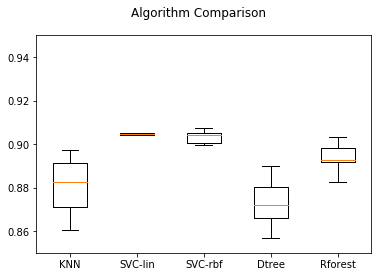

In [25]:
# evaluate each model in turn
results_test = []
# ,Nbayes"
names = ["KNN","SVC-lin","SVC-rbf","Dtree","Rforest"]
for i in [0,1,2,3,4]:
    results_test.append(results[i]["mean_test_score"])
 
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_test)
plt.ylim(0.85,0.95) 
ax.set_xticklabels(names)
plt.show()


It will be explained how the information provided by each box diagram is shown with respect to the solutions obtained for each algorithm:
- KNN boxplot:  the accuracy results obtained are symmetric because the orange line represents the median and this coincides with the average, therefore, there is not much fluctuation above or below the average threshold of solutions.

- SVC-lin boxplot:there is almost no variation in the accuracy values since the box plot is almost one line, there are no abnormal accuracy values greater than 1.5 times the upper interquartile.

- SVC-Rbf boxplot:  it is the one that most variance represents its solutions since it has a larger boxplot, besides, it reports few solutions above the upper interquartile range and more above the lower interquartile range. The mean does not coincide with the mean, therefore there are more solutions below the central value, that is, precision metrics of a value lower than the one represented by the median are obtained, therefore the precision of the solutions oscillates inferiorly.

- DTree boxplot: it has a set of total symmetric precision and therefore the mean will coincide with the median and fairly similar accuracy values will always be obtained.


- RForest boxplot: presents a low variance in the accuracy values, a fairly symmetric boxplot and few values above and below the upper and lower interquartile ranges.

Spherical points have a value greater than 1.5 times the interquartile range are considered outliers.

###### conclusiones:
Any of the algorithms used gets very similar precision, even though some have a bit of overfitting. The one that best represents precision when asked for an example that I have not seen before are SVC Linear and SVC Gaussian, either one would be a good option. In my opinion, as the precision difference between the two is 0.5% and the linear SVC has a lower computational cost, I would choose this one.

### Decision Tree Classifier in terms of max_depth

In [26]:
param_grid = { 'criterion':['gini'],'max_depth': np.arange(2, 15)}
dtree_model=DecisionTreeClassifier()

dtree_gscv = GridSearchCV(estimator=dtree_model, param_grid=param_grid, cv=5,verbose=0,n_jobs=5,return_train_score=True)
dtree_gscv.fit(X_train_pca, y_train)
    
results = dtree_gscv.cv_results_
best_tree = dtree_gscv.best_estimator_
    
y_pred_best = best_tree.predict(X_test_pca)
tree_acc = 100*accuracy_score(y_test,y_pred_best)

In [28]:
dtree_gscv

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=5,
             param_grid={'criterion': ['gini'],
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13

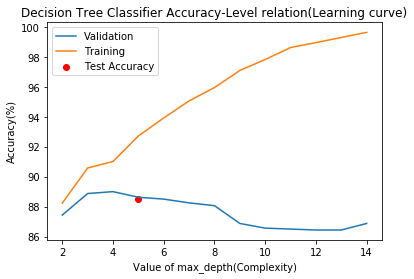

In [29]:
#Plotting
test = results["mean_test_score"]
train = results["mean_train_score"]
plt.plot(np.arange(2, 15),test*100,label='Validation')
plt.plot(np.arange(2, 15),train*100,label='Training')
plt.scatter(5,tree_acc,color="red",label = "Test Accuracy")
plt.title("Decision Tree Classifier Accuracy-Level relation(Learning curve)")
plt.xlabel("Value of max_depth(Complexity)")
plt.ylabel("Accuracy(%)")
plt.legend()

##performance of model

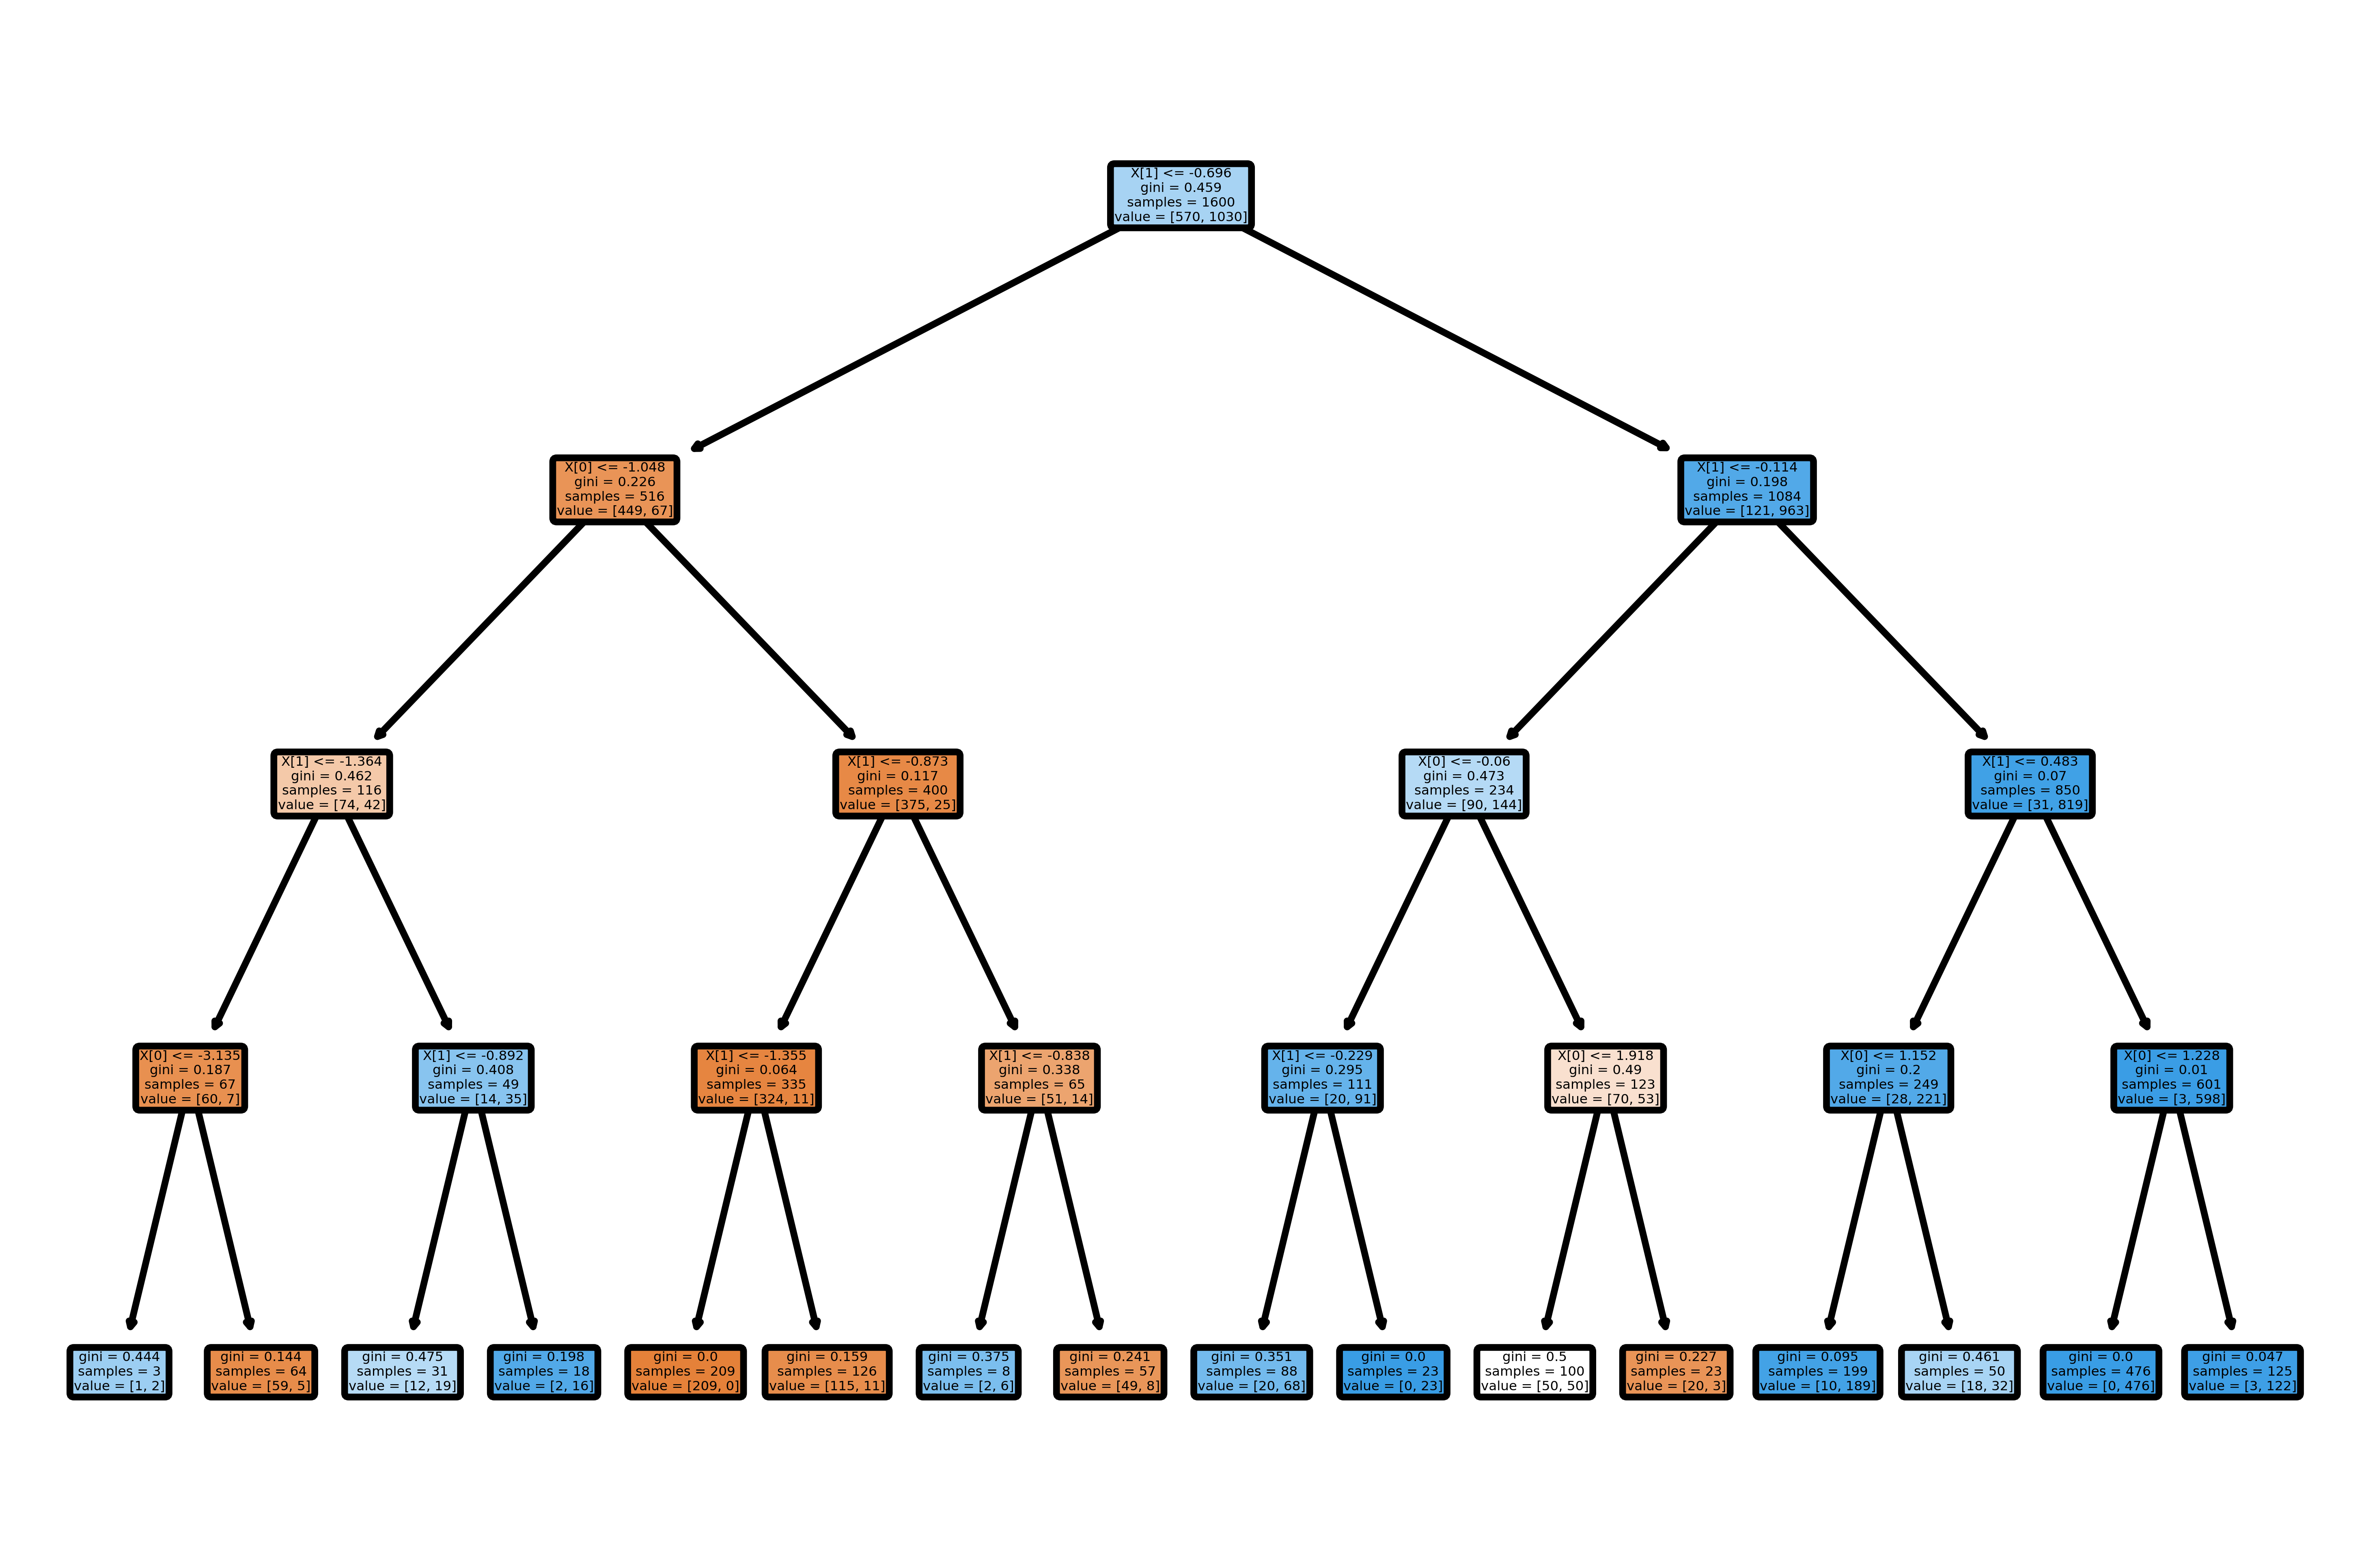

In [30]:
from sklearn.tree import plot_tree
fig = plt.figure(dpi=1200)
plot_tree(best_tree,rounded=True,filled=True)
plt.show()

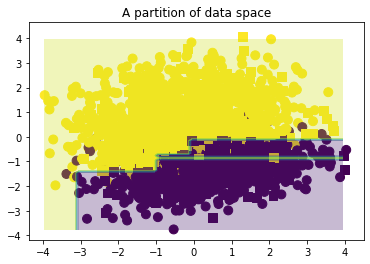

In [31]:
plt.subplot(121)

plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=y_train)

X_test_pca = miPCA.transform(X_test)
plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_test)

plt.subplot(111)
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=y_train)
plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_pred_best)

import numpy as np

x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = best_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("A partition of data space")


plt.contourf(xx, yy, Z, alpha=0.3)


## Classification with SVM-C

/Users/sedaaykutlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sedaaykutlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


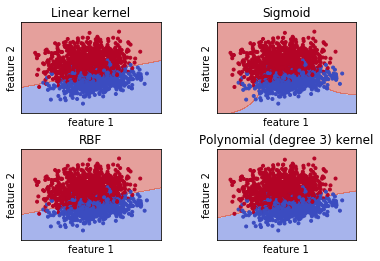

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with


h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X_train_pca, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.01, C=C).fit(X_train_pca, y_train)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X_train_pca, y_train)
sigmo_svc = svm.SVC(kernel='sigmoid', C=0.3,coef0=3.461).fit(X_train_pca, y_train)

# create a mesh to plot in
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['Linear kernel',
          'Sigmoid',
          'RBF',
          'Polynomial (degree 3) kernel']


for i, clf in enumerate((svc, sigmo_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)

    # Plot also the training points
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='.')
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

##### An attempt has been made to find the kernel that best suits the problem to be solved. For the Sigmoid type kernel, we have searched adjusting some parameter coef0 that represents the cut-off point with the axis "feature 2" and parameter C, which is a regularization parameter, and we have obtained a model that defines  two regions with acceptable precision. However, the kernels that best generalize for this problem are: linear, guassian (RBF) and polynomial of degree 3, therefore, if one had to choose one to definitively implement a machine vector support classifier algorithm, it would be linear. I would choose this since it is the least expensive at the computational level.

## Learning curve of Random Forest

In [33]:
param_grid = {"max_depth" : np.arange(1,21,2)} 

forest = RandomForestClassifier()
forest_gscv= GridSearchCV(forest, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
forest_gscv.fit(X_train, y_train)

results = forest_gscv.cv_results_
best_forest = forest_gscv.best_estimator_
    
y_pred_forest = best_forest.predict(X_test)
forest_acc = 100*accuracy_score(y_test,y_pred_forest)

/Users/sedaaykutlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [34]:
best_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

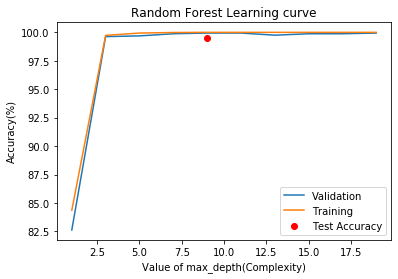

In [36]:
#Plotting
test = results["mean_test_score"]
train = results["mean_train_score"]

plt.plot(np.arange(1,21,2),test*100,label='Validation')
plt.plot(np.arange(1,21,2),train*100,label='Training')
plt.scatter(9,forest_acc,color="red",label = "Test Accuracy")
plt.title("Random Forest Learning curve")
plt.xlabel("Value of max_depth(Complexity)")
plt.ylabel("Accuracy(%)")
plt.legend()


## Learning Curves of SVM(RBF kernel)

### Score in terms of gamma values

In [37]:
gamma=np.logspace(-5, -1, 5)

param_grid = {'C': [100], 'gamma': gamma }
svc_rbf = SVC(kernel = 'rbf', random_state = 0)
rbf_gscv = GridSearchCV(svc_rbf, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
rbf_gscv.fit(X_train_pca, y_train)
    
best_model = rbf_gscv.best_estimator_
y_pred = best_model.predict(X_test_pca)
acc = accuracy_score(y_test,y_pred)
    
score_test2 = (rbf_gscv.cv_results_["mean_test_score"])
score_train2 = rbf_gscv.cv_results_["mean_train_score"]
train_std = rbf_gscv.cv_results_["std_train_score"]
test_std =rbf_gscv.cv_results_["std_test_score"]  

In [38]:
best_model

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

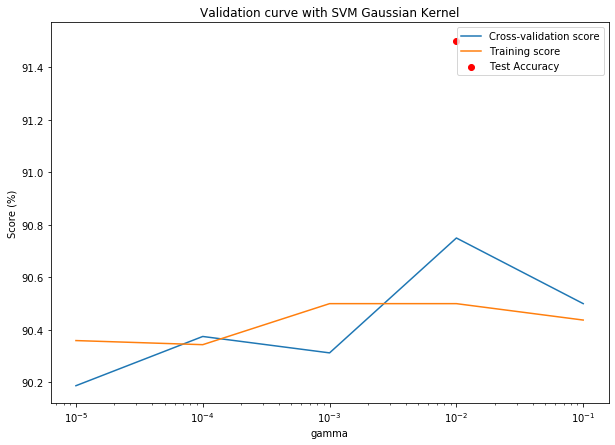

In [40]:
plt.figure(figsize=(10,7))
plt.semilogx(gamma,score_test2*100,label="Cross-validation score")
plt.semilogx(gamma,score_train2*100,label="Training score")
plt.scatter(0.01,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve with SVM Gaussian Kernel")
plt.xlabel("gamma")
plt.ylabel("Score (%)")
plt.legend(loc="best")
plt.show()

### Score in terms of C values

In [41]:
c=np.arange(0.01, 150, 0.01)

param_grid = {'C': c, 'gamma': [0.01] }
svc_rbf = SVC(kernel = 'rbf', random_state = 0)
rbf_gscv = GridSearchCV(svc_rbf, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
rbf_gscv.fit(X_train_pca, y_train)
    
best_model = rbf_gscv.best_estimator_
y_pred = best_model.predict(X_test_pca)
acc = accuracy_score(y_test,y_pred)
    
score_test2 = (rbf_gscv.cv_results_["mean_test_score"])
score_train2 = rbf_gscv.cv_results_["mean_train_score"]
train_std = rbf_gscv.cv_results_["std_train_score"]
test_std =rbf_gscv.cv_results_["std_test_score"]  

In [42]:
best_model

SVC(C=130.78, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

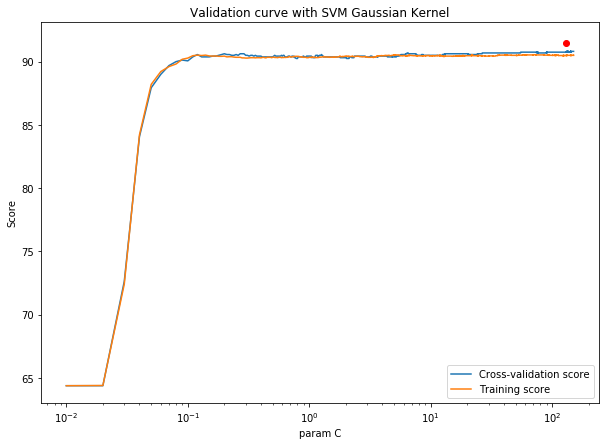

In [44]:
plt.figure(figsize=(10,7))
plt.semilogx(c,score_test2*100,label="Cross-validation score")
plt.semilogx(c,score_train2*100,label="Training score")
plt.scatter(130.78,acc*100,color="red")
plt.title("Validation curve with SVM Gaussian Kernel")
plt.xlabel("param C")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

## Learning Curves of SVM(Linear kernel)

### Score in terms of C param values

In [45]:
c=np.arange(0.1,10.2,0.2)
num=len(c)
param_grid = {'C': c }
svc_linear = SVC(kernel = 'linear', random_state = 0)
linear_gscv = GridSearchCV(svc_linear, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
linear_gscv.fit(X_train_pca, y_train)
    
best_model = linear_gscv.best_estimator_
y_pred = best_model.predict(X_test_pca)
acc = accuracy_score(y_test,y_pred)
    
score_test2 = (linear_gscv.cv_results_["mean_test_score"])
score_train2 = linear_gscv.cv_results_["mean_train_score"]
train_std = linear_gscv.cv_results_["std_train_score"]
test_std =linear_gscv.cv_results_["std_test_score"]  

In [46]:
best_model

SVC(C=4.1000000000000005, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

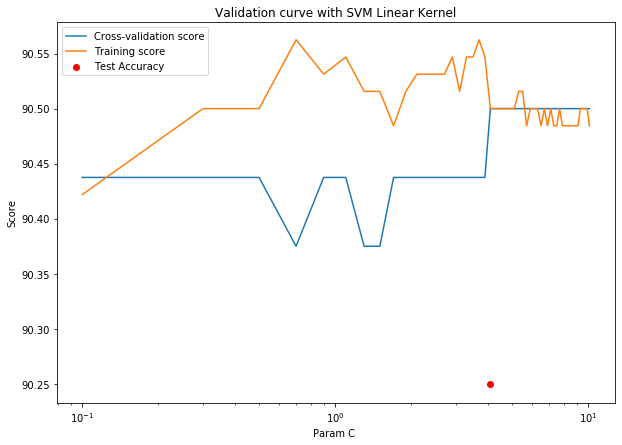

In [48]:
plt.figure(figsize=(10,7))
plt.semilogx(c,score_test2*100,label="Cross-validation score")
plt.semilogx(c,score_train2*100,label="Training score")
plt.scatter(4.1000000000000005,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve with SVM Linear Kernel")
plt.xlabel("Param C ")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

##  Learning Curves of SVM(Polynomial kernel) 

### Score in terms of Degree values of the polynomial of the kernel.

In [49]:
Degree=np.arange(1, 10, 1)

param_grid = {'C': [0.30000000000000004], 'degree': Degree }
svc_poly = SVC(kernel = 'poly', random_state = 0)
poly_gscv_d = GridSearchCV(svc_poly, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
poly_gscv_d.fit(X_train_pca, y_train)
    
best_model_poly = poly_gscv_d.best_estimator_
y_pred = best_model_poly.predict(X_test_pca)
acc = accuracy_score(y_test,y_pred)
    
score_test2 = (poly_gscv_d.cv_results_["mean_test_score"])
score_train2 = poly_gscv_d.cv_results_["mean_train_score"]
train_std = poly_gscv_d.cv_results_["std_train_score"]
test_std =poly_gscv_d.cv_results_["std_test_score"]  

/Users/sedaaykutlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [50]:
best_model_poly

SVC(C=0.30000000000000004, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

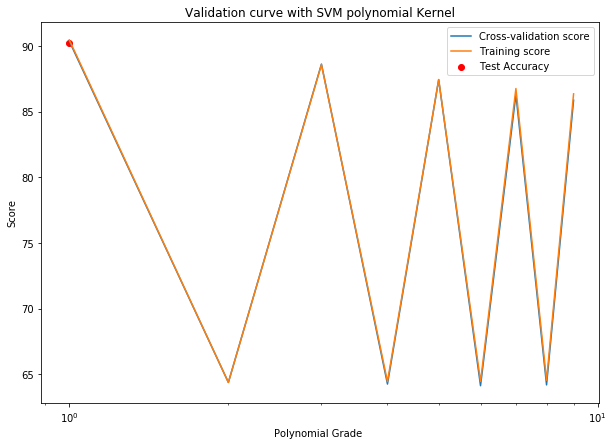

In [51]:
plt.figure(figsize=(10,7))
plt.semilogx(Degree,score_test2*100,label="Cross-validation score")
plt.semilogx(Degree,score_train2*100,label="Training score")
plt.scatter(1,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve with SVM polynomial Kernel")
plt.xlabel("Polynomial Grade ")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [52]:
poly_gscv_d.cv_results_

{'mean_fit_time': array([1.81597710e-02, 4.48432446e-02, 3.31441879e-02, 2.92483425e-01,
        3.53081799e-01, 1.06037240e+02, 4.74544997e+00, 1.50462261e+03,
        1.52405007e+02]),
 'std_fit_time': array([3.04488789e-03, 4.11712290e-03, 8.53083722e-03, 8.07007178e-02,
        8.78267254e-02, 1.15506157e+02, 4.93100742e+00, 1.14292657e+03,
        1.25192482e+02]),
 'mean_score_time': array([0.00407777, 0.01216259, 0.00256023, 0.00650439, 0.00368075,
        0.00421853, 0.00208302, 0.01688719, 0.00636683]),
 'std_score_time': array([1.75116318e-03, 4.04926467e-03, 5.24264763e-04, 1.44148716e-03,
        7.35092701e-04, 6.91886280e-05, 4.09212415e-05, 1.31839666e-02,
        3.05187618e-03]),
 'param_C': masked_array(data=[0.30000000000000004, 0.30000000000000004,
                    0.30000000000000004, 0.30000000000000004,
                    0.30000000000000004, 0.30000000000000004,
                    0.30000000000000004, 0.30000000000000004,
                    0.3000000000000

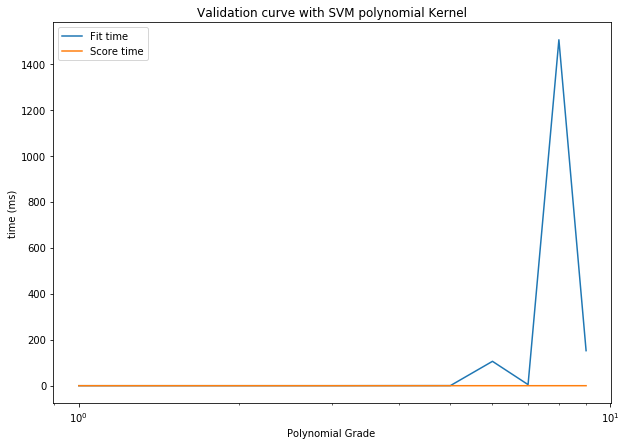

In [53]:
fit_time = poly_gscv_d.cv_results_["mean_fit_time"]
score_time= poly_gscv_d.cv_results_["mean_score_time"]
plt.figure(figsize=(10,7))
plt.semilogx(Degree,fit_time,label="Fit time")
plt.semilogx(Degree,score_time,label="Score time")
#plt.scatter(1,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve with SVM polynomial Kernel")
plt.xlabel("Polynomial Grade ")
plt.ylabel("time (ms)")
plt.legend(loc="best")
plt.show()

### Score in terms of param C of the polynomial of the kernel.

In [54]:
c=np.arange(0.01, 5, 0.01)

param_grid = {'C': c, 'degree': [3] }
svc_poly = SVC(kernel = 'poly', random_state = 0)
poly_gscv_c = GridSearchCV(svc_poly, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
poly_gscv_c.fit(X_train_pca, y_train)
    
best_model_poly = poly_gscv_c.best_estimator_
y_pred = best_model_poly.predict(X_test_pca)
acc = accuracy_score(y_test,y_pred)
    
score_test2 = (poly_gscv_c.cv_results_["mean_test_score"])
score_train2 = poly_gscv_c.cv_results_["mean_train_score"]
train_std = poly_gscv_c.cv_results_["std_train_score"]
test_std =poly_gscv_c.cv_results_["std_test_score"]  

/Users/sedaaykutlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


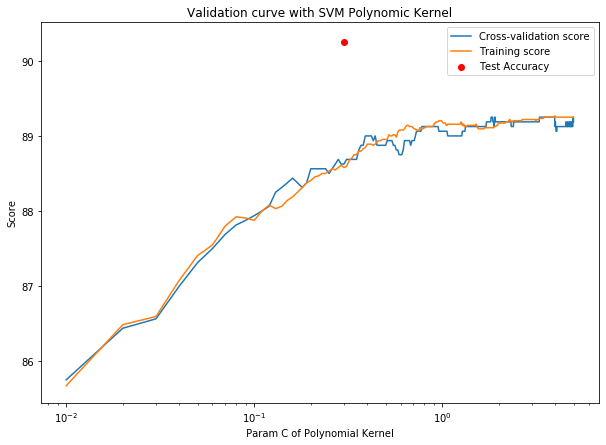

In [55]:
plt.figure(figsize=(10,7))
plt.semilogx(c,score_test2*100,label="Cross-validation score")
plt.semilogx(c,score_train2*100,label="Training score")
plt.scatter(0.3,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve with SVM Polynomic Kernel")
plt.xlabel(" Param C of Polynomial Kernel ")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

### Score in terms of param coef0 values of the polynomial of the kernel.

In [56]:
cf=np.arange(0.01, 5, 0.01)

param_grid = {'C': [0.30000000000000004], 'degree': [3], 'coef0': cf}
svc_poly = SVC(kernel = 'poly', random_state = 0)
poly_gscv_cf = GridSearchCV(svc_poly, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
poly_gscv_cf.fit(X_train_pca, y_train)
    
best_model_poly = poly_gscv_cf.best_estimator_
y_pred = best_model_poly.predict(X_test_pca)
acc = accuracy_score(y_test,y_pred)
    
score_test2 = (poly_gscv_cf.cv_results_["mean_test_score"])
score_train2 = poly_gscv_cf.cv_results_["mean_train_score"]
train_std = poly_gscv_cf.cv_results_["std_train_score"]
test_std =poly_gscv_cf.cv_results_["std_test_score"]  

/Users/sedaaykutlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [57]:
best_model_poly

SVC(C=0.30000000000000004, cache_size=200, class_weight=None, coef0=0.89,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

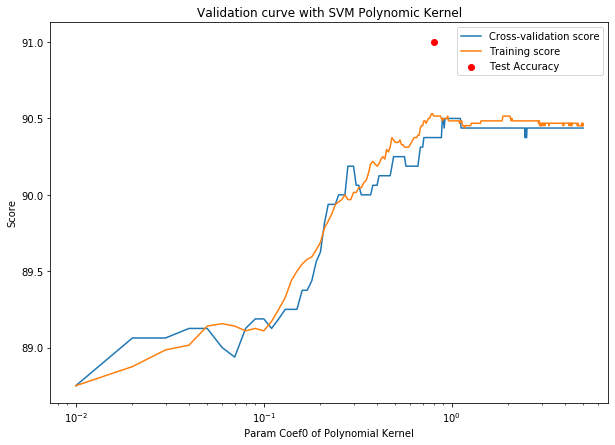

In [58]:
plt.figure(figsize=(10,7))
plt.semilogx(cf,score_test2*100,label="Cross-validation score")
plt.semilogx(cf,score_train2*100,label="Training score")
plt.scatter(0.8,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve with SVM Polynomic Kernel")
plt.xlabel(" Param Coef0 of Polynomial Kernel ")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

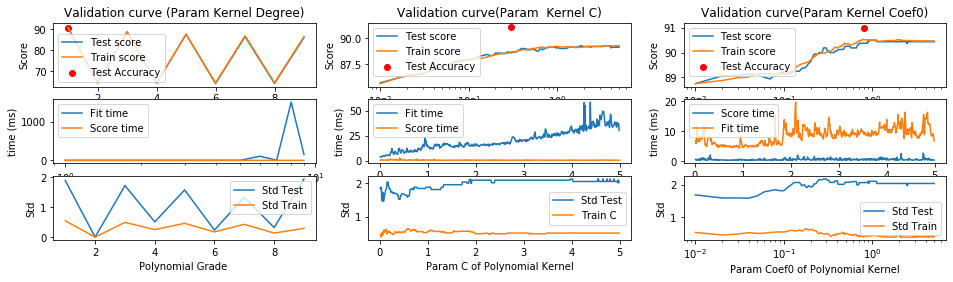

In [59]:
f = plt.figure(figsize=(16,4))
#param degree
best_model_poly_d = poly_gscv_d.best_estimator_
y_pred_d = best_model_poly_d.predict(X_test_pca)
acc_d = accuracy_score(y_test,y_pred_d)


#param c
best_model_poly_c = poly_gscv_c.best_estimator_
y_pred_c = best_model_poly_c.predict(X_test_pca)
acc_c = accuracy_score(y_test,y_pred_c)

#param coef0
best_model_poly_cf = poly_gscv_cf.best_estimator_
y_pred_cf = best_model_poly_cf.predict(X_test_pca)
acc_c = accuracy_score(y_test,y_pred_cf)

plt.subplots_adjust(wspace= None, hspace= None)

f.add_subplot(331)


plt.plot(Degree,poly_gscv_d.cv_results_["mean_test_score"]*100,label="Test score")
plt.plot(Degree,poly_gscv_d.cv_results_["mean_train_score"]*100,label="Train score")
plt.scatter(1,acc_d*100,color="red",label = "Test Accuracy")
plt.title("Validation curve (Param Kernel Degree)")
plt.xlabel("Polynomial Grade ")
plt.ylabel("Score")
plt.legend(loc="best")

f.add_subplot(334)


plt.semilogx(Degree,poly_gscv_d.cv_results_["mean_fit_time"],label="Fit time")
plt.semilogx(Degree,poly_gscv_d.cv_results_["mean_score_time"],label="Score time")
#plt.scatter(1,acc*100,color="red",label = "Test Accuracy")
#plt.title("Validation curve with SVM polynomial Kernel")
plt.xlabel("Polynomial Grade ")
plt.ylabel("time (ms)")
plt.legend(loc="best")

f.add_subplot(337)
plt.plot(Degree,poly_gscv_d.cv_results_["std_test_score"]*100,label="Std Test")
plt.plot(Degree,poly_gscv_d.cv_results_["std_train_score"]*100,label="Std Train")
plt.xlabel("Polynomial Grade ")
plt.ylabel("Std")
plt.legend(loc="best")

f.add_subplot(332)


plt.semilogx(c,poly_gscv_c.cv_results_["mean_test_score"]*100,label="Test score")
plt.semilogx(c,poly_gscv_c.cv_results_["mean_train_score"]*100,label="Train score")
plt.scatter(0.3,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve(Param  Kernel C)")
plt.xlabel(" Param C of Polynomial Kernel ")
plt.ylabel("Score")
plt.legend(loc="best")

f.add_subplot(335)

plt.plot(c,poly_gscv_c.cv_results_["mean_fit_time"]*100,label="Fit time")
plt.plot(c,poly_gscv_c.cv_results_["mean_score_time"]*100,label="Score time")
plt.xlabel(" Param C of Polynomial Kernel")
plt.ylabel("time (ms)")
plt.legend(loc="best")


f.add_subplot(338)

plt.plot(c,poly_gscv_c.cv_results_["std_test_score"]*100,label="Std Test")
plt.plot(c,poly_gscv_c.cv_results_["std_train_score"]*100,label="Train C")
plt.xlabel("Param C of Polynomial Kernel")
plt.ylabel("Std")
plt.legend(loc="best")

f.add_subplot(333)

plt.semilogx(cf,poly_gscv_cf.cv_results_["mean_test_score"]*100,label="Test score")
plt.semilogx(cf,poly_gscv_cf.cv_results_["mean_train_score"]*100,label="Train score")
plt.scatter(0.8,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve(Param Kernel Coef0)")
plt.xlabel(" Param Coef0 of Polynomial Kernel ")
plt.ylabel("Score")
plt.legend(loc="best")

f.add_subplot(336)
plt.plot(cf,poly_gscv_cf.cv_results_["mean_score_time"]*100,label="Score time")
plt.plot(cf,poly_gscv_cf.cv_results_["mean_fit_time"]*100,label="Fit time")
plt.xlabel(" Param Coef0 of Polynomial Kernel ")
plt.ylabel("time (ms)")
plt.legend(loc="best")

f.add_subplot(339) 
plt.semilogx(cf,poly_gscv_cf.cv_results_["std_test_score"]*100,label="Std Test")
plt.semilogx(cf,poly_gscv_cf.cv_results_["std_train_score"]*100,label="Std Train")
plt.xlabel("Param Coef0 of Polynomial Kernel")
plt.ylabel("Std")
plt.legend(loc="best")




plt.show()

In [60]:
gamma=np.arange(0.01, 5, 0.01)

param_grid = {'C': [0.30000000000000004], 'degree': [1], 'coef0': [0.8], 'gamma': gamma}
svc_poly= SVC(kernel = 'poly', random_state = 0)
poly_gscv_g = GridSearchCV(svc_poly, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
poly_gscv_g.fit(X_train_pca, y_train)
    
best_model_poly = poly_gscv_g.best_estimator_
y_pred = best_model_poly.predict(X_test_pca)
acc = accuracy_score(y_test,y_pred)
    
score_test2 = (poly_gscv_g.cv_results_["mean_test_score"])
score_train2 = poly_gscv_g.cv_results_["mean_train_score"]
train_std = poly_gscv_g.cv_results_["std_train_score"]
test_std =poly_gscv_g.cv_results_["std_test_score"] 

In [61]:
best_model_poly

SVC(C=0.30000000000000004, cache_size=200, class_weight=None, coef0=0.8,
    decision_function_shape='ovr', degree=1, gamma=0.04, kernel='poly',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

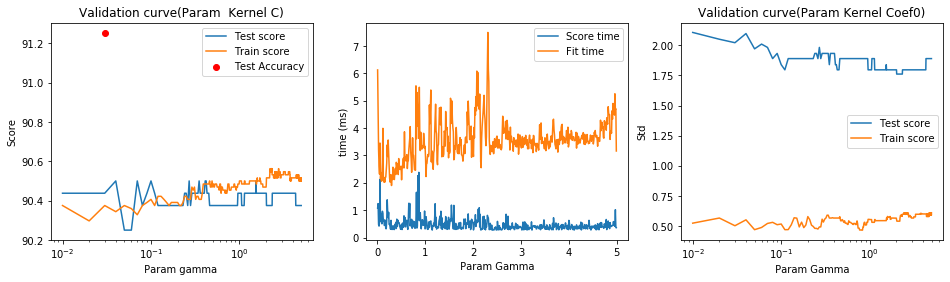

In [62]:
f = plt.figure(figsize=(16,4))
f.add_subplot(131) 
plt.semilogx(gamma,poly_gscv_g.cv_results_["mean_test_score"]*100,label="Test score")
plt.semilogx(gamma,poly_gscv_g.cv_results_["mean_train_score"]*100,label="Train score")
plt.scatter(0.03,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve(Param  Kernel C)")
plt.xlabel(" Param gamma  ")
plt.ylabel("Score")
plt.legend(loc="best")

f.add_subplot(133)

plt.semilogx(gamma,poly_gscv_g.cv_results_["std_test_score"]*100,label="Test score")
plt.semilogx(gamma,poly_gscv_g.cv_results_["std_train_score"]*100,label="Train score")
#plt.scatter(0.8,acc*100,color="red",label = "Test Accuracy")
plt.title("Validation curve(Param Kernel Coef0)")
plt.xlabel(" Param Gamma ")
plt.ylabel("Std")
plt.legend(loc="best")

f.add_subplot(132)
plt.plot(gamma,poly_gscv_g.cv_results_["mean_score_time"]*100,label="Score time")
plt.plot(gamma,poly_gscv_g.cv_results_["mean_fit_time"]*100,label="Fit time")
plt.xlabel(" Param Gamma ")
plt.ylabel("time (ms)")
plt.legend(loc="best")

### Score in terms of number of samples for best SVM-C without PCA:
 #### Hyperparameters:
       - Degree of polynomianl kernel: Degree = 1
       - Independent coefficient of polynomial kernel: coef0 = 0.8
       - Regularization parameter: C = 0.30000000000000004
       - Kernel coeffcicient: gamma= 0.03

In [64]:
seed=0
score_test=[]
score_train=[]
numbers=[]
time=[]
points_test=[]
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    data2 = pd.read_csv('electrical_grid_stability.csv')
    data = data2.sample(frac=i,random_state=seed)
    data['stabf'] = LabelEncoder().fit_transform(data['stabf'])
    numbers.append(data.shape[0])
    X = data.drop(["stabf"],axis=1)
    y = data["stabf"]
    X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y,test_size=0.20)
    param_grid = {'C': [0.30000000000000004], 'gamma': [0.03], 'degree': [1], 'coef0': [0.8]}
    svc_poly = SVC(kernel = 'poly', random_state = 0)
    poly_gscv = GridSearchCV(svc_poly, param_grid, cv=5,verbose=0,n_jobs=5,scoring="accuracy",return_train_score=True)
    poly_gscv.fit(X_train, y_train)
    score_test.append(poly_gscv.cv_results_["mean_test_score"]*100)
    score_train.append(poly_gscv.cv_results_["mean_train_score"]*100)
    time.append(poly_gscv.cv_results_["mean_fit_time"])

    best_model_poly = poly_gscv.best_estimator_
    y_pred = best_model_poly.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    points_test.append(acc*100)

                      
    

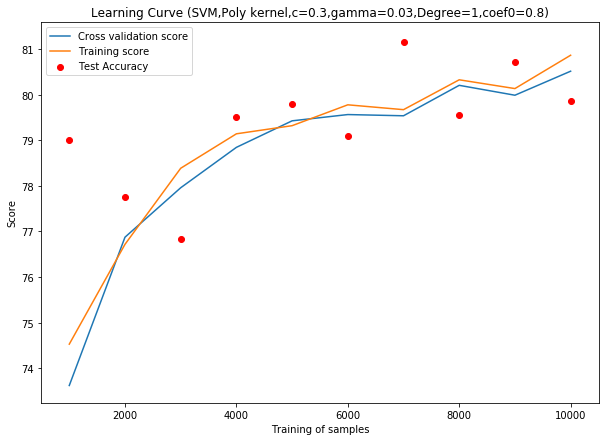

In [65]:
plt.figure(figsize=(10,7))
plt.plot(numbers,score_test,label='Cross validation score')
plt.plot(numbers,score_train,label='Training score')
#represent the point of the test
#num_samples =np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])*len(data2)
#points_test = np.array(points_test)
plt.scatter(numbers,points_test,color="red",label = "Test Accuracy")


plt.title("Learning Curve (SVM,Poly kernel,c=0.3,gamma=0.03,Degree=1,coef0=0.8)")
plt.xlabel("Training of samples")
plt.ylabel("Score")
plt.legend()

### Performance and Scalability of model

Text(0, 0.5, 'Score')

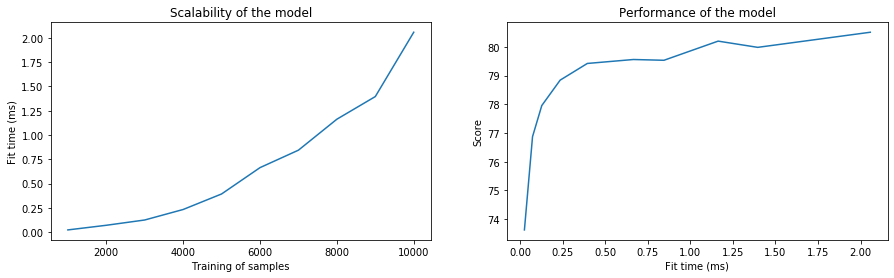

In [66]:
f = plt.figure(figsize=(15,4))

f.add_subplot(121)
plt.plot(numbers,time,label=" ")

plt.title("Scalability of the model")
plt.xlabel("Training of samples")
plt.ylabel("Fit time (ms)")

f.add_subplot(122)
plt.plot(time,score_test,label=" " )

plt.title("Performance of the model")
plt.xlabel("Fit time (ms)")
plt.ylabel("Score")

